#### Setup

In [9]:
from pandas_datareader import data as web
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

#### Obtenção dos dados

Período de avaliação das ações

In [62]:
start_date = datetime.datetime(2022,1,1)
end_date = datetime.datetime(2022,12,23)

Preparação das ações a serem avaliadas.

Neste caso, opções que eu conheço e que eu desejo investir

In [80]:
# houve uma alteração no retorno do yahoo finance e esta linha é necessária até que o Pandas DataReader seja corrigido.
yf.pdr_override()
#Gerdau
goau = web.get_data_yahoo(['GOAU4.SA'], start=start_date, end=end_date)
#Copel
cple = web.get_data_yahoo(['CPLE6.SA'], start=start_date, end=end_date)
# Assaí
asai = web.get_data_yahoo(['ASAI3.SA'], start=start_date, end=end_date)
#Itaú
itub = web.get_data_yahoo(['ITUB4.SA'], start=start_date, end=end_date)
#Natura
ntco = web.get_data_yahoo(['NTCO3.SA'], start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Visualizando o desempenho das ações ao longo do ano

Text(0.5, 1.0, 'Natura')

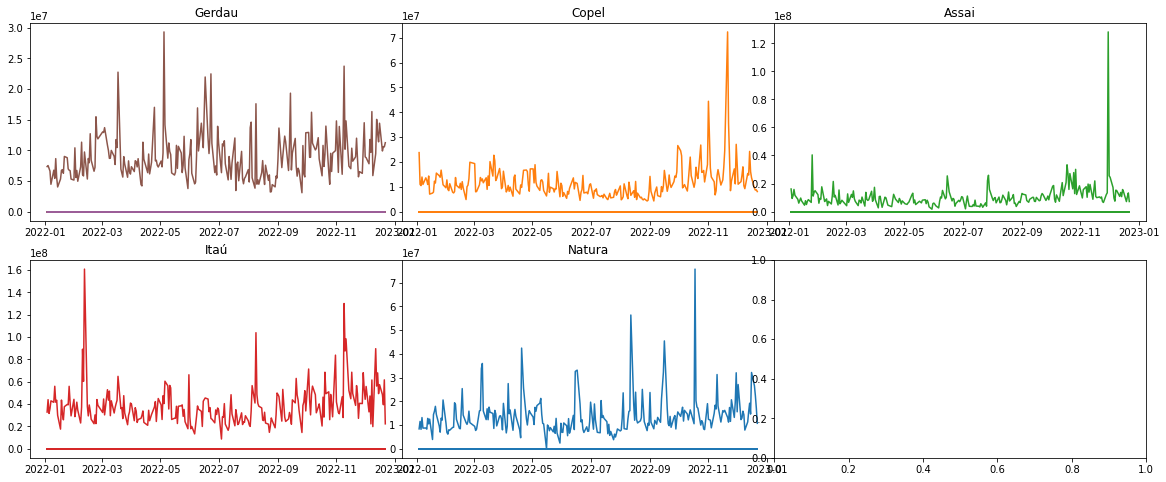

In [100]:
fig = plt.figure(figsize=(20,8))
gs = fig.add_gridspec(2, 3, wspace = 0)
(ax1, ax2, ax3), (ax4, ax5, ax6) = gs.subplots()
ax1.plot(goau)
ax1.set_title('Gerdau')

ax2.plot(cple, 'tab:orange')
ax2.set_title('Copel')

ax3.plot(asai, 'tab:green')
ax3.set_title('Assai')

ax4.plot(itub, 'tab:red')
ax4.set_title('Itaú')

ax5.plot(ntco, 'tab:blue')
ax5.set_title('Natura')


Unindo os dataframes com dados de cada ação.

Neste caso queremos apenas o valor de fechamento

In [82]:
# com o concat será feita a união dos dataframes. A opção axis indica que queremos os dados sejam colocados em colunas diferentes ao invés de concatenar as linhas
stocks = pd.concat([
    goau['Close'], 
    cple['Close'], 
    asai['Close'],
    itub['Close'],
    ntco['Close']
    ],axis= 1)
# agora renomeamos as colunas para que tenham o nome de suas respectivas ações
stocks.columns = ['goau', 'cple', 'asai', 'itub', 'ntco']

stocks.head(5)

,goau,cple,asai,itub,ntco
Date,,,,,
2022-01-03,11.29,6.43,12.72,21.510000,25.900000
2022-01-04,11.52,6.36,12.72,22.120001,24.230000
2022-01-05,11.29,6.28,11.99,21.700001,23.110001
2022-01-06,11.26,6.12,11.59,22.139999,22.850000
2022-01-07,11.43,6.10,11.36,22.629999,22.110001


#### Calculo do retorno

$$
R_t = \frac{P_t}{P_t - 1}\
$$
Onde: 
 - *R* é o retorno esperado
 - *P* é o preço
 - *P*-1 é o preço anterior

Todos os elementos são subscritos (t), ou seja, todos são em função do tempo.


In [83]:
# neste caso o shift faz o LAG do valor, ou seja, pega o valor correspondente ao dia anterior
returns = stocks / stocks.shift(1)
# vemos que os primeiros valores são inválidos pois não há uma data anterior para o cálculo
returns.head(5)

,goau,cple,asai,itub,ntco
Date,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN
2022-01-04,1.020372,0.989114,1.000000,1.028359,0.935521
2022-01-05,0.980035,0.987421,0.942610,0.981013,0.953776
2022-01-06,0.997343,0.974522,0.966639,1.020276,0.988749
2022-01-07,1.015098,0.996732,0.980155,1.022132,0.967615


Padronização dos valores

Como temos escalas diferentes nos valores nas ações, precisamos padronizá-los. Para isso usaremos a função log que colocará os valores em uma escala de -1 a 1

A fórmula neste caso é:

$$
{log r_t} = {log} \frac{P_t}{P_T -1}\
$$

In [84]:
log_returns = np.log(returns)
# podemos ver que agora os valores, que antes oscilavam entre R$ 6 (CPLE) e R$ 21 (ITUB), agora oscilam entre -1 e 1
log_returns.head(5)

,goau,cple,asai,itub,ntco
Date,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.020167,-0.010946,0.000000,0.027964,-0.066651
2022-01-05,-0.020167,-0.012658,-0.059103,-0.019170,-0.047326
2022-01-06,-0.002661,-0.025808,-0.033930,0.020074,-0.011314
2022-01-07,0.014985,-0.003273,-0.020044,0.021891,-0.032921


#### Sharpe ratio

Este índice considera o retorno de acordo com o risco envolvido, utilizando dados históricos

$$
SR(w) = \frac{R(w)-R_f}{\sigma(w)}\
$$
Onde 
 - SR é o Sharpe Ratio, o valor que desejamos obter
 - (w) é o peso de cada ação. Neste caso o valor normalizado de todos os os valores de nossa lista, ou seja, ao somar todos os valores teremos 1 como resultado. Esse valor irá ajudar a definir o percential de nosso investimento em cada ação. Neste exemplo, w1 é PETR4, w2 é NTCO e assim por diante
 - R(f) é o retorno caso não exista risco, e como veremos mais adiante é um valor despresado, não precisaremos dele.
 - Sigmna é desvio padrão ou volatilidade

*w* é a soma dos pesos dentro de um determinado dia

$$
(w) = [w_1\ w_2\ w_3\ w_4]
$$

*R(w)* - retorno do inverstimento: matriz transposta dos pesso multiplicado pelo valor do dia anterior (log)

$$
R(w) = w^t\ log(r)
$$

*sigma(w)* - risco do investimento é a raiz da matriz transposta de pesos  multiplicado pela soma dos pesos 

$$
{\sigma(w)} = \sqrt{w^t\sum\nolimits_{}^{}{w}}\
$$

Ao final teremos a formula que será utilizada:
$$
SR(w) ~ \frac{w^t log(r)}{\sqrt{w^t\sum\nolimits_{}^{}{w}}}\
$$



Calculando o retorno vs volatilidade

Neste caso avaliaremos 10000 diferentes portfólios, gerando peso aleatórios para todos para cada uma das ações

In [85]:
number_of_portfolios = 10000
number_of_stocks = len(stocks.columns)

# vamos criar os vetores que serão utilizados e iniciá-los com zero
weights = np.zeros((number_of_portfolios, number_of_stocks))
expected_return = np.zeros(number_of_portfolios)
expected_volatility = np.zeros(number_of_portfolios)
sharpe_ratio = np.zeros(number_of_portfolios)

# Como utilizaremos a média dos retornos padromizados (log_returns), vamos calculá-la agora para evitar 
# processamento excessivo durante o loop
mean_log_returns = log_returns.mean()

# utilizaremos a matriz de covariancia (grau de interdependência) entre as ações de nossa base
sigma = log_returns.cov()

# vamos correr todo o portfólio, quanto maior o número de iterações maior a quantidade combinações a serem feitas
for i in range(number_of_portfolios):
    
    # (w)
    # criar vetor com pesos aleatórios, usado em cada uma das iterações
    w = np.array(np.random.random(number_of_stocks))
    # encontra o percentual de cada peso gerado anteriormente
    w = w / np.sum(w)
    
    # salva o valor dentro da matriz
    weights[i,:] = w
    
    # R(w)
    # calcular o log return multiplicando o valor com LAG pelo peso. Esta matriz terá apenas uma coluna, com o retorno
    # esperado para aquele dia de todas as açoes da carteira
    expected_return[i] = np.sum(mean_log_returns * w)

    # sigma(w)
    expected_volatility[i] = np.sqrt(
        np.dot(
            w.T,
            np.dot(sigma, w)
        )
    )

    # Sharpe ratio, o retorno dividido pela volatilidade
    sharpe_ratio[i] = expected_return[i] / expected_volatility[i]

#### Maximização do Sharpe Ratio

Retorna o maior sharpe ratio calculado de acordo com os dados disponívei

In [86]:
# retorna a posição que garante o maior retorno nas ações de acordo com o sharpe ratio
max_index = sharpe_ratio.argmax()

# agora podemos ver qual o percentual de nosso orçamento que podemos alocar em cada uma das ações para maximizar nosso retorno.
weights[max_index, :]


array([0.13479279, 0.10927835, 0.63245738, 0.12176291, 0.00170856])

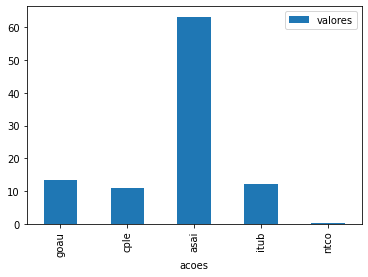

In [103]:
df = pd.DataFrame({'acoes':['goau', 'cple', 'asai', 'itub', 'ntco'], 'valores':weights[max_index, :] * 100})
ax = df.plot.bar(x='acoes', y='valores', rot=0, )

#### Visualização dos dados caluclados

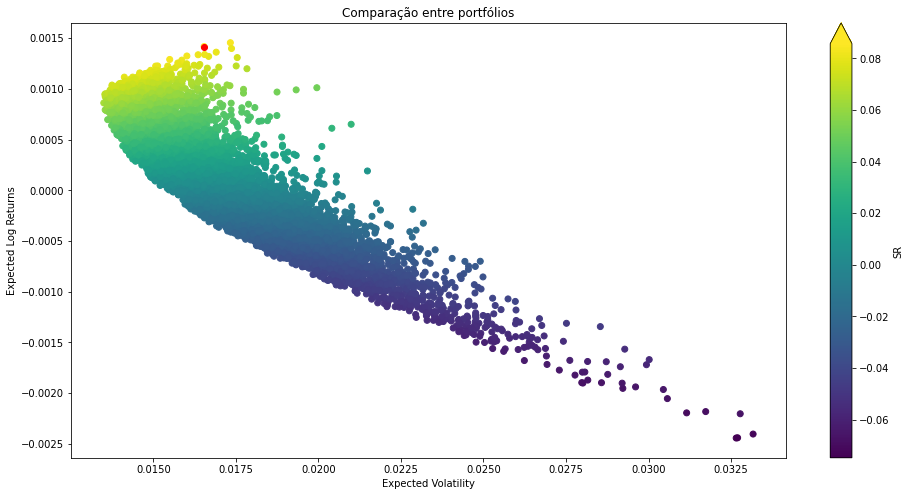

In [104]:
plt.figure(figsize=(16,8))
# plota a volatilidade e o retorno classificado de acordo com o maior valor do Sharpe Ratio
plt.scatter(expected_volatility, expected_return, c=sharpe_ratio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.title('Comparação entre portfólios')
plt.colorbar(label = 'SR', extend = 'max')
# plota em vermelho o max_index, ou seja, o ponto de maior retorno e menor risco
plt.scatter(expected_volatility[max_index], expected_return[max_index], c='red')
plt.show()

Podemos observar no gráfico acima que os maiores retornos (em amarelo) estão no limite superior de nossa amostra, e cabe ao investidor avaliar o risco (eixo X) que deseja correr para alcançar aquele retorno.

O ponto vermelho indica o maior retorno que podemos ter com o menor risco possível.

#### Criação do melhor portfólio, ou o Efficient Markowitz Frontier

Agora vamos calcular, para cada cenário de retorno o risco ao qual estaremos expostos. Essa área é conhecida como fronteira eficiente de Markowitz.

Para saber mais seu conceito, recomendo a leitura do texto do Erik Kawano no link: http://clubedefinancas.com.br/materias/fronteira-eficiente/

In [32]:
# função que retorno o sharpe ratio negativo de um determinado peso
def negative_sharpe_ratio(weight):
    weight = np.array(weight)
    return_ = np.sum(mean_log_returns * weight)
    volatility_ = np.sqrt(np.dot(weight.T, np.dot(sigma, weight)))
    sharpe_ratio_ = return_ / volatility_
    return -1 * sharpe_ratio_

def check_sum_to_one(weight):
    return np.sum(weight) - 1

# peso inicial, valores iguais para todos os elementos
w0 = ([1/len(stocks.columns)]) * len(stocks.columns)

def get_return(weight):
    weight = np.array(weight)
    return np.sum(mean_log_returns * weight)

bounds = ([(0,1)])*len(stocks.columns)


In [34]:
returns = np.linspace(0, np.max(expected_return), 25)
volatility_opt = []

# função para minimizar a volatilidade
def minimize_volatility(weight):
    weight = np.array(weight)
    return np.sqrt(np.dot(weight.T, np.dot(sigma, weight)))
    
# faremos um loop nos valores de retorno buscando o menor risco possível ou a volatilidade ótima (volatility_opt)
# para isso uzaremos a função minimize do pacote scipy
for r in returns:
    #encontrar melhor volatilidade
    constraints = (
        {'type':'eq', 'fun':check_sum_to_one},
        {'type':'eq', 'fun': lambda weight: get_return(weight) - r}
    )
    opt = minimize(minimize_volatility, w0, 
       method='SLSQP', 
        bounds=bounds, 
        constraints = constraints
    )

    volatility_opt.append(opt['fun'])


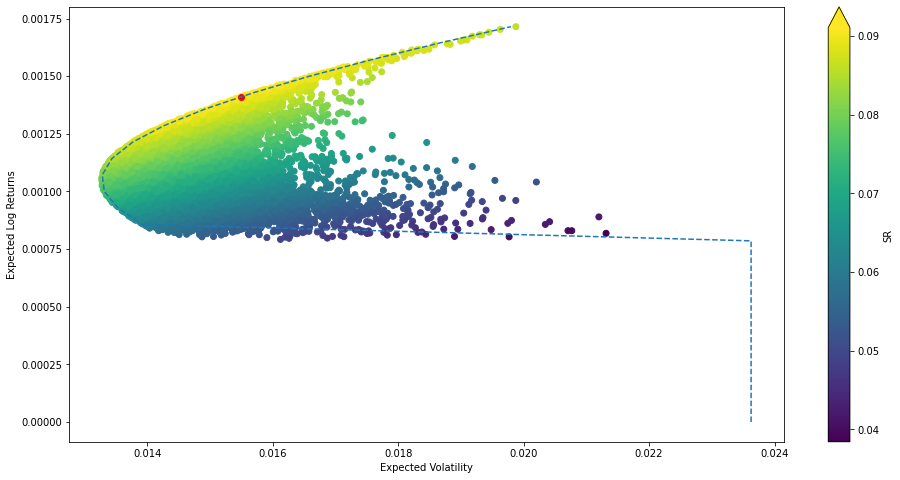

In [31]:
plt.figure(figsize=(16,8))
# plota a volatilidade e o retorno classificado de acordo com o maior valor do Sharpe Ratio
plt.scatter(expected_volatility, expected_return, c=sharpe_ratio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label = 'SR', extend = 'max')
# plota em vermelho o max_index, ou seja, o ponto de maior retorno e menor risco
plt.scatter(expected_volatility[max_index], expected_return[max_index], c='red')
plt.plot(volatility_opt, returns, '--')
plt.show()

Podemos observar que os valores com melhor retorno estão no limite onde o retorno é maior vs o risco.

Não de estranhar que o ponto de maior retorno (em vermelho) está exatamente sobre a fronteira (linha pontilhada)

In [229]:
# x representa o melhor valor
# nit apresenta o número de iterações necessárias
print(w_optimal.x[:].real)
#np.sum(w_optimal.x)

[0.00000000e+00 2.01470661e-16 6.67766137e-01 3.32233863e-01]
